In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, regularizers, backend as K
from keras import losses

In [ ]:
# Threading setup (must come before any TensorFlow usage)
os.environ["OMP_NUM_THREADS"] = "24"
os.environ["TF_NUM_INTRAOP_THREADS"] = "24"
os.environ["TF_NUM_INTEROP_THREADS"] = "4"
tf.config.set_visible_devices([], 'GPU')
tf.config.threading.set_intra_op_parallelism_threads(24)
tf.config.threading.set_inter_op_parallelism_threads(4)
# --- CONFIG ---
train_files = [
    "parsed_emg/subject_1/trial_12(left).csv",
    "parsed_emg/subject_1/trial_10(left).csv",
    "parsed_emg/subject_1/trial_8(left).csv",
    "parsed_emg/subject_1/trial_6(left).csv",
    "parsed_emg/subject_1/trial_4(left).csv"
]
test_file = "parsed_emg/subject_1/trial_2(left).csv"
label_col = 5
sequence_length = 40
batch_size = 64
learning_rate = 1e-3
epochs = 1
num_classes = 3

# --- LOAD + NORMALIZE + SEQUENCE ---
def load_csv(path):
    df = pd.read_csv(path, skiprows=1)
    X = df.iloc[:, 1:5].values.astype("float32")
    y = df.iloc[:, label_col].values.astype("int32")
    return X, y

def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i + seq_len])
        y_seq.append(y[i + seq_len])
    return np.array(X_seq), np.array(y_seq)



Epoch 1/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 321s 9ms/step - accuracy: 0.4889 - loss: 1.0398 - val_accuracy: 0.5422 - val_loss: 0.9425
Epoch 2/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 303s 9ms/step - accuracy: 0.5584 - loss: 0.9318 - val_accuracy: 0.6043 - val_loss: 0.8552
Epoch 3/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 310s 9ms/step - accuracy: 0.5802 - loss: 0.8999 - val_accuracy: 0.5804 - val_loss: 0.8841
Epoch 4/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 309s 9ms/step - accuracy: 0.5938 - loss: 0.8793 - val_accuracy: 0.5736 - val_loss: 0.9046
Epoch 5/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 318s 9ms/step - accuracy: 0.6021 - loss: 0.8640 - val_accuracy: 0.5962 - val_loss: 0.8595
Epoch 6/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 323s 10ms/step - accuracy: 0.6101 - loss: 0.8503 - val_accuracy: 0.5912 - val_loss: 0.8642
Epoch 7/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 326s 10ms/step - accuracy: 0.6162 - loss: 0.8396 - val_accuracy: 0.6130 - val_loss: 0.8524
Epoch 8/10
33636/33636 ━━━━━━━━━━━━━━━━━━━━ 502s 15ms/step -

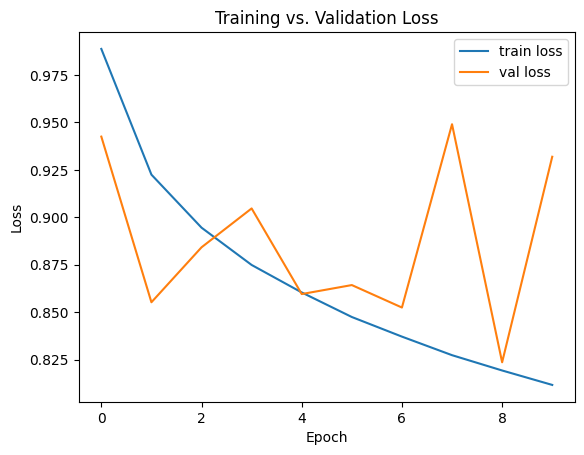

4406/4406 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


<Figure size 640x480 with 0 Axes>

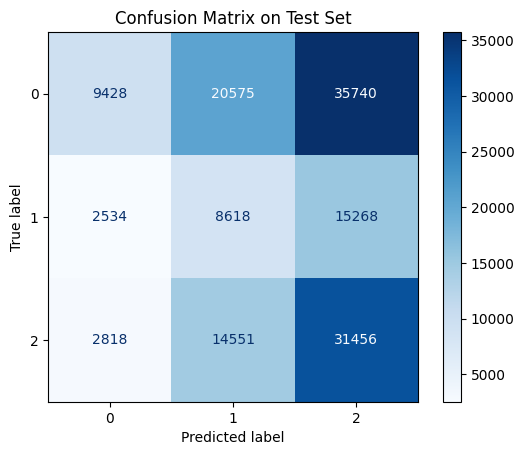

In [ ]:
raw_X_all, raw_y_all = [], []
for f in train_files:
    X, y = load_csv(f)
    raw_X_all.append(X)
    raw_y_all.append(y)
raw_X_all = np.concatenate(raw_X_all)
raw_y_all = np.concatenate(raw_y_all)

# Normalize training data
scaler = MinMaxScaler(feature_range=(-1, 1))
raw_X_all = scaler.fit_transform(raw_X_all)

# Create sequences
X_train_seq, y_train_seq = create_sequences(raw_X_all, raw_y_all, sequence_length)

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_seq),
    y=y_train_seq
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(
    X_train_seq, y_train_seq, test_size=0.1, random_state=42, stratify=y_train_seq
)

# Datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# --- TEST SET ---
X_test_raw, y_test_raw = load_csv(test_file)
X_test_raw = scaler.transform(X_test_raw)
X_test, y_test = create_sequences(X_test_raw, y_test_raw, sequence_length)

# --- MODEL ---
model = tf.keras.Sequential([
    layers.Input(shape=(sequence_length, 4)),

    # Conv Block 1
    layers.Conv1D(128, kernel_size=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(64, kernel_size=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.25),

    # Conv Block 2
    layers.Conv1D(128, kernel_size=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv1D(128, kernel_size=1, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.25),

    # Bidirectional LSTM stack
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32, return_sequence=True)),
    
    # Dense Layers
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# --- TRAINING ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    class_weight=class_weight_dict
)

# --- EVALUATION ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc:.2f}, Test loss: {test_loss:.2f}")

# --- PLOTS ---
# 1) Loss curves
plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs. Validation Loss')
plt.show()

# 2) Confusion matrix
y_pred = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, y_pred, labels=range(num_classes))
disp = ConfusionMatrixDisplay(cm, display_labels=range(num_classes))
plt.figure()
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix on Test Set')
plt.show()